In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html
import tensorflow as tf
from transformers import BertTokenizerFast
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore", message="`resume_download` is deprecated")

In [ ]:
data = pd.read_csv("IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
print(f'No of Rows: {data.shape[0]}')
print(f'No of Columns: {data.shape[1]}')

No of Rows: 50000
No of Columns: 2


In [7]:
data.ndim

2

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
is_duplicate = data.duplicated().any()
print(is_duplicate)

True


In [10]:
duplicate = data.duplicated().sum()
print(duplicate)

418


In [11]:
data.describe(include='all').transpose()

,count,unique,top,freq
review,50000,49582,Loved today's show!!! It was a variety and not...,5
sentiment,50000,2,positive,25000


In [12]:
unique = data.nunique()
print(unique)

review       49582
sentiment        2
dtype: int64


In [13]:
null_values = data.isnull().sum()
print(null_values)

review       0
sentiment    0
dtype: int64


## Remove Duplicates

In [14]:
data = data.drop_duplicates()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


## Font Style

In [16]:
font_style = {'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 12}

## Sentiment Distribution

In [17]:
sentiment_count = data['sentiment'].value_counts()
sentiment_count

,count
sentiment,
positive,24884
negative,24698


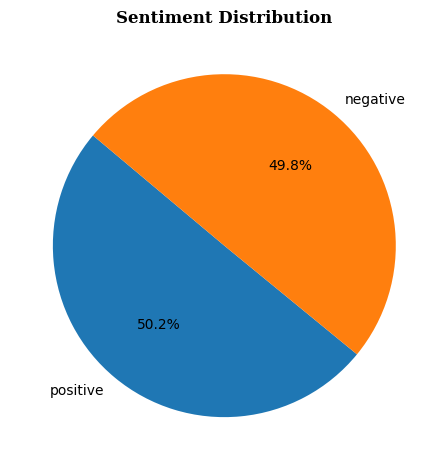

In [18]:
plt.pie(sentiment_count, labels=sentiment_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution',fontdict=font_style)
plt.tight_layout()
plt.show()

In [19]:
length = data["review"].astype(str).apply(len)

max_length = length.max()
print(f'Maximum length of review: {max_length}')
min_length = length.min()
print(f'Minimum length of review: {min_length}')
mean_length = length.mean()
print(f'Mean length of review: {mean_length}')

Maximum length of review: 13704
Minimum length of review: 32
Mean length of review: 1310.5682304061959


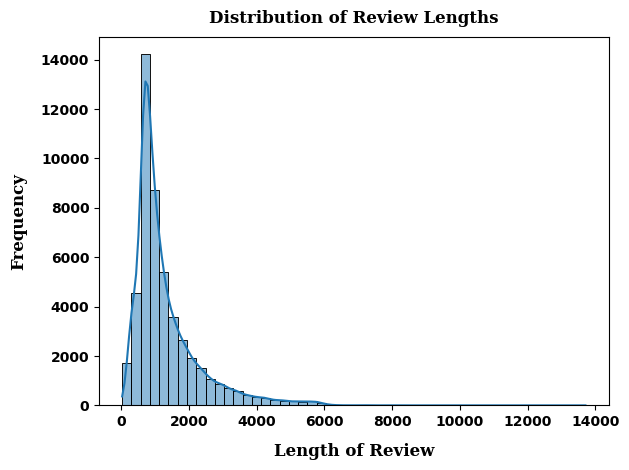

In [20]:
sns.histplot(length, bins=50, kde=True)
plt.title('Distribution of Review Lengths', fontdict=font_style,pad=10)
plt.xlabel('Length of Review', fontdict=font_style, labelpad=10)
plt.ylabel('Frequency', fontdict=font_style,labelpad=10)
plt.xticks(fontsize=10,weight='bold')
plt.yticks(fontsize=10,weight='bold')
plt.tight_layout()
plt.show()

## Checking Emoji's

In [21]:
def contains_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & Map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE
    )
    return bool(emoji_pattern.search(text))

In [22]:
is_emoji_present = data['review'].apply(contains_emoji)
emoji_count = is_emoji_present.value_counts()

print(f'Number of reviews containing emojis: {is_emoji_present.sum()}')
print(f'Number of reviews not containing emojis: {emoji_count[False].sum()}')

Number of reviews containing emojis: 4
Number of reviews not containing emojis: 49578


In [23]:
emoji = data[is_emoji_present]
emoji

,review,sentiment
3827,"This was such a terrible film, almost a comedy...",negative
44503,This review contains spoilers.<br /><br />I wa...,negative
48150,i guess if they are not brother this film will...,positive
49200,"""A Damsel in Distress"" is definitely not one o...",negative


## Data cleaning Process

In [24]:
def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r"<.*?>", "", text)                    # Remove HTML tags
    text = re.sub(r"http\S+|www\S+", "[URL]", text)      # Replace URLs
    return text.lower()

In [25]:
data["cleaned_review"] = data["review"].apply(clean_text)
data.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is..."


In [26]:
final_data = data.drop(columns=["review"])
final_data.head()

,sentiment,cleaned_review
0,positive,one of the other reviewers has mentioned that ...
1,positive,a wonderful little production. the filming tec...
2,positive,i thought this was a wonderful way to spend ti...
3,negative,basically there's a family where a little boy ...
4,positive,"petter mattei's ""love in the time of money"" is..."


In [27]:
final_data["sentiment"] = final_data["sentiment"].map({"positive": 1, "negative": 0})
final_data.head()

,sentiment,cleaned_review
0,1,one of the other reviewers has mentioned that ...
1,1,a wonderful little production. the filming tec...
2,1,i thought this was a wonderful way to spend ti...
3,0,basically there's a family where a little boy ...
4,1,"petter mattei's ""love in the time of money"" is..."


In [28]:
texts = final_data["cleaned_review"].to_list()
labels = final_data["sentiment"].to_list()


In [29]:
texts_trainval, texts_test, labels_trainval, labels_test = train_test_split(
    texts, labels, test_size=0.1, random_state=42
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts_trainval, labels_trainval, test_size=0.2, random_state=42
)

In [30]:
tokenizer = BertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(texts_test, truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


In [31]:
def create_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices({
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "labels": tf.convert_to_tensor(labels)
    })

In [32]:
train_dataset = create_tf_dataset(train_encodings, train_labels)
val_dataset = create_tf_dataset(val_encodings, val_labels)
test_dataset = create_tf_dataset(test_encodings, labels_test)

In [33]:
train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [34]:
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [[tf.keras.metrics.SparseCategoricalAccuracy(name = "accuracy")]]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [36]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model', save_best_only=True, save_format="tf")
]

In [37]:
model.fit(train_dataset,validation_data=val_dataset,epochs=4,callbacks=callbacks)

Epoch 1/4
1116/1116 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.8552

1116/1116 [==============================] - 530s 453ms/step - loss: 0.3270 - accuracy: 0.8552 - val_loss: 0.2731 - val_accuracy: 0.8862
Epoch 2/4
1116/1116 [==============================] - 490s 439ms/step - loss: 0.1970 - accuracy: 0.9218 - val_loss: 0.3217 - val_accuracy: 0.8878
Epoch 3/4
1116/1116 [==============================] - 490s 439ms/step - loss: 0.1039 - accuracy: 0.9616 - val_loss: 0.3524 - val_accuracy: 0.8836
Epoch 4/4
1116/1116 [==============================] - 492s 441ms/step - loss: 0.0534 - accuracy: 0.9823 - val_loss: 0.3936 - val_accuracy: 0.8884


In [38]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
print("\n🚀 Evaluating on Test Set:")
results = model.evaluate(test_dataset)

for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")


🚀 Evaluating on Test Set:
155/155 [==============================] - 21s 138ms/step - loss: 0.2871 - accuracy: 0.8822
loss: 0.2871
accuracy: 0.8822


In [40]:
model.save_pretrained("final_sentiment_model")
tokenizer.save_pretrained("final_sentiment_model")

('final_sentiment_model/tokenizer_config.json',
 'final_sentiment_model/special_tokens_map.json',
 'final_sentiment_model/vocab.txt',
 'final_sentiment_model/added_tokens.json',
 'final_sentiment_model/tokenizer.json')

In [41]:
# Load model and tokenizer
model = TFAutoModelForSequenceClassification.from_pretrained("final_sentiment_model")
tokenizer = AutoTokenizer.from_pretrained("final_sentiment_model")

# Prepare input
text = "This movie is very bad!"
inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)

# Remove token_type_ids if present (DistilBERT doesn't use it)
if "token_type_ids" in inputs:
    del inputs["token_type_ids"]

# Predict
outputs = model(inputs)
pred = tf.argmax(outputs.logits, axis=1).numpy()[0]
print("Predicted label:", "Positive" if pred == 1 else "Negative")

Some layers from the model checkpoint at final_sentiment_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at final_sentiment_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: Negative


In [ ]:
!zip -r model.zip final_sentiment_model/

  adding: final_sentiment_model/ (stored 0%)
  adding: final_sentiment_model/vocab.txt (deflated 53%)
  adding: final_sentiment_model/tokenizer_config.json (deflated 75%)
  adding: final_sentiment_model/config.json (deflated 42%)
  adding: final_sentiment_model/tokenizer.json (deflated 71%)
  adding: final_sentiment_model/tf_model.h5 (deflated 8%)
  adding: final_sentiment_model/special_tokens_map.json (deflated 42%)


In [44]:
from google.colab import files
files.download("model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
!zip -r best_model.zip best_model/
files.download("best_model.zip")

  adding: best_model/ (stored 0%)
  adding: best_model/fingerprint.pb (stored 0%)
  adding: best_model/assets/ (stored 0%)
  adding: best_model/variables/ (stored 0%)
  adding: best_model/variables/variables.index (deflated 78%)
  adding: best_model/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: best_model/saved_model.pb (deflated 92%)
  adding: best_model/keras_metadata.pb (deflated 94%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>